# Setup

In [27]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import h5py
import copy
import random
import pandas as pd
import keras_tuner as kt
import pandas as pd
from scipy import stats
from numba import cuda
from sklearn.model_selection import train_test_split as _train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow_probability import distributions
from tensorflow_probability import math
from tensorflow_probability import distributions
from tensorflow_probability import math as tfpmath

# workaround to import pdn and CLR from another forlder while they are not installed
import sys
sys.path.insert(0,'../ML_tracer_painting/')
sys.path.insert(0,'./')

#import pdn
import clr_callback as CLR

In [28]:
%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [29]:
directory_path = "/home/draco/work/quijote/"

## My attempt on Processing the Data
#### Data Processing
I am trying to have a single dataframe with all the normalised parameters and the powerspectrums. There are 2k rows for the 2k Latin hypercube simulations. The frist five columns represent the normalised 5 Vanilla $\Lambda CDM$ model - $\Omega_m$,$\Omega_b$, $h$,$n_s$,$\sigma_8$respectively and the next columns are the values of the matter power spectrum at different scales.

In [50]:
# Reading the data

pk = pd.read_csv(directory_path+"Pk_lh.csv")[:32].T                      # taking transpose to keep in check the dimensionality
pk.reset_index(drop = True,inplace=True)                            # dropiing index for concatenating the P_k data with the parameters 
params = pd.read_csv(directory_path+"lh_params.csv",index_col= 0)   # laoding the vanilla parameters data

#normalising the parameters
mean_params = params.mean(axis=0).values
std_params = params.std(axis = 0).values
norm_params = (params - mean_params)/std_params

# Concatenating the params and pk

df = pd.concat([norm_params,pk],axis = 1)


P_k = df[df.columns[5:]]
van_labels = df[df.columns[:5]]
params

,Omega_m,Omega_b,h,n_s,sigma_8
simulation_no.,,,,,
0,0.1755,0.06681,0.7737,0.8849,0.6641
1,0.2139,0.05557,0.8599,0.9785,0.8619
2,0.1867,0.04503,0.6189,0.8307,0.7187
3,0.3271,0.06875,0.6313,0.8135,0.8939
4,0.1433,0.06347,0.6127,1.1501,0.7699
...,...,...,...,...,...
1995,0.1791,0.06145,0.6935,0.8179,0.9573
1996,0.4365,0.06281,0.7347,1.0699,0.9509
1997,0.1611,0.03709,0.8161,1.0743,0.9983


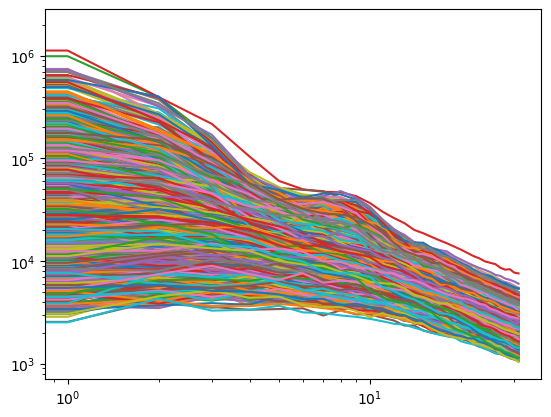

In [47]:
plt.plot(P_k.T)

plt.loglog()
plt.show()

The first 5 columns of our data set $("df")$ are the labels which are the the normalised 5 Vanilla $\Lambda CDM$ model and the rest are the Power spectrum values $P_{K}$. Now, we split the data into training set, validation set and test set. Here, I am permuting the dataset to avoid any bias.

In [6]:
def train_val_test_split(df,params = 5,random_state =1, train_frac = 0.6,test_frac = 0.2):
    # Permuting the DataFrame.
    
    df = df.sample(frac=1,random_state=random_state) 

    #seperating the input and labels in the df

    X = df[df.columns[params:]]
    y = df[df.columns[:params]]
    


    # Splitting into training, test and validation

    train_frac = train_frac
    test_frac =  test_frac
    val_frac = 1- (train_frac+test_frac)
    
#     assert train_frac + val_frac + test_frac == 1,"Fraction should add up to 1" # to ensure that the sum is one

    # defining the size for training, test and validation
    
    train_size, test_size, val_size = map(lambda frac: round(len(df) * frac), [train_frac, test_frac, val_frac])

    X_train, X_val, X_test, y_train, y_val, y_test = X[:train_size],X[train_size:train_size+test_size],X[train_size+test_size:],\
                                                     y[:train_size],y[train_size:train_size+test_size],y[train_size+test_size:]
    
    return(X_train, X_val, X_test, y_train, y_val, y_test)

In [49]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df)
y_train


,Omega_m,Omega_b,h,n_s,sigma_8
674,1.602612,-0.194807,-0.785289,0.778362,-1.017326
1699,-1.212998,0.894381,-1.088322,-0.946329,-1.038105
1282,-1.318627,-0.847627,1.225120,-1.510837,-1.235509
1315,-0.684855,0.125542,0.580958,-1.391355,0.778362
1210,0.125542,-1.209535,-1.315164,-1.124686,-0.665807
...,...,...,...,...,...
752,0.341995,-0.535936,-1.384429,0.071862,0.109958
121,-0.397406,-0.049351,0.863212,-0.468403,0.709098
699,-0.037230,1.476204,-1.536811,0.790484,0.052814
876,0.683123,-0.504767,1.076201,1.226851,0.378359


In [8]:
# inputs = Input(shape= X_train.shape[1])
# normalize_layer = layers.Normalization()
# normalize_layer.adapt(X_train)
# norm_inputs = normalize_layer(inputs)
# model = Model(inputs=inputs, outputs=norm_inputs)
# norm_outputs = model.predict(X_train)
# norm_outputs.shape

#################################################################
# Andrea's Code                                               #
#################################################################

# Define couple of useful functions

In [33]:
# Function defining loss plot.

def plot_loss(histories, ylim=None, logy=False):
    plt.figure(figsize=(12,8 ))
    
    plt.plot(histories.index, df_history['loss'], label='loss')
    plt.plot(histories.index, df_history['val_loss'], label='val_loss')

    
#     for key, history in histories.items():
#         plt.plot(
#             np.array(range(len(history.history['val_loss'])))-0.5, 
#             history.history['loss'], 
#             label='loss'
#         )
#         plt.plot(history.history['val_loss'], label='val_loss')

    if logy:
        plt.semilogy()
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
#     print(key)
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()

In [10]:
# #Split the available dataset in the train validation and test set

# def train_val_test_split(
#         properties,
#         labels,
#         val_fraction = 0.2,
#         test_fraction = 0.2,
#         random_state=1,
# ):
#     test_size = round(len(properties) * test_fraction)
#     val_size = round(len(properties) * val_fraction)

#     train_prop, test_prop, train_lab, test_lab = _train_test_split(
#           properties, labels, 
#           test_size=test_size, random_state=random_state)

#     train_prop, val_prop, train_lab, val_lab = _train_test_split(
#           train_prop, train_lab,
#           test_size=val_size, random_state=random_state)
    
#     return train_prop, val_prop, test_prop, train_lab, val_lab, test_lab

# Load pre-processed data

Load the target variables from file

In [11]:
# filename = directory_path+"Pk_LH/latin_hypercube_params.txt"

# labels_van = np.loadtxt(
#     filename,
#     skiprows=1
# )
# f = open(filename)
# header = f.readline()
# f.close()

In [34]:
# label_names_vanilla = [
#     "Omega_m",
#     "Omega_b",
#     "h",
#     "n_s",
#     "sigma_8",
# ]

label_LaTeX_names_vanilla = [
    r"$\Omega_m$",
    r"$\Omega_b$",
    r"$h$",
    r"$n_s$",
    r"$\sigma_8$"
]

Target variables are normalized so that they have mean=0 and std=0

In [13]:
# sigmas_van = []
# means_van = []

# for i in range(len(labels_van[0])):
#     s = np.std(labels_van[:,i])
#     m = np.mean(labels_van[:,i])
#     labels_van[:,i] = (labels_van[:,i] - m)/s
#     sigmas_van.append(s)
#     means_van.append(m)

In [14]:
# def get_data_dict(
#         data,
#         first_feature_index,
#         val_fraction = 0.2,
#         test_fraction = 0.2,
#         random_state = 1,
# ):    
    
#     data_dict = {
#         "train" : {},
#         "val" : {},
#         "test" : {},
#     }
    
#     lbl = data[:,0:first_feature_index].copy()
#     ftr = data[:,first_feature_index:].copy()    
    
#     data_dict["train"]["ftr"],\
#     data_dict["val"]["ftr"],\
#     data_dict["test"]["ftr"],\
#     data_dict["train"]["lbl"],\
#     data_dict["val"]["lbl"],\
#     data_dict["test"]["lbl"] = \
#     train_val_test_split(
#         ftr, lbl,
#         val_fraction,
#         test_fraction,
#         random_state,
#     )
    
#     return data_dict

In [15]:
# P0 = []
# for i in range(2000):
#     P0.append(np.loadtxt(directory_path+"Pk_LH/Pk/"+str(i)+"/Pk_m_z=0.txt")[:32,1] ) # The indeces select kmax = 0.2 and [k, Pk]
# P0 = np.array(P0)

# data_LH_vanilla = {}
# data_LH_vanilla["P0"] = np.concatenate(( labels_van, P0 ), axis=1)

# for x in data_LH_vanilla.keys():
#     data_LH_vanilla[x] = get_data_dict(np.array(data_LH_vanilla[x]), 5)

In [16]:
# plt.plot(P0.T)
# plt.loglog()

# plt.show()

# Analysis

Create layers

In [35]:
# training_set_properties = X_train #data_LH_vanilla["P0"]["train"]["ftr"]

# defining elu+1 before as it is used below. not sure why? - elu gives a negative output however for the sigma values we need a positive definitness so we elu+1 helps with that but i dont know how to implement it

def elu_plus_one(x):
    return (tf.keras.activations.elu(x)+1)

def create_layers(architecture, dropout_rate):

    # the features are normalized to have mean=0 and std=1
    inputs = Input(shape=X_train.shape[1])
    normalize_layer = layers.Normalization()
    normalize_layer.adapt(X_train)
    norm_inputs = normalize_layer(inputs)
    input_layer = norm_inputs

# Adding hidden dense layers which is specified by the architecture in our case its 3 layers with 32 neurons each
  

    for n_nodes in architecture:
        d_layer = layers.Dense(n_nodes,
                              activation="selu",
                              kernel_initializer="he_normal",)(input_layer)

        
# Each followed by a dropout layer  to apply dropout regularisation to the o/p of the d_layer which is then assigned to the input_layer for the next iteration which is the two dense layer mean and sigma our output layers
        
        
        input_layer = layers.Dropout(dropout_rate)(d_layer)


# Add the output layer combining means and sigmas
   
    
    means = layers.Dense(
        5,
        activation="linear",
        kernel_initializer="he_normal",
    )(input_layer)

    sigmas = layers.Dense(
        5, 
        activation="ReLU", # ????is there any particular reason for using elu+1? -doesnt work
        kernel_initializer="he_normal",
    )(input_layer)

    output_layer = layers.Concatenate()([means, sigmas])
    
    return inputs, output_layer

Define loss

In [36]:
def mse_means_and_sigmas_uncorrelated(y_true, y_pred):
    means_pred, sigmas_pred = tf.split(y_pred, num_or_size_splits=2, axis=1)
    
    y_true = tf.cast(y_true, dtype=y_pred.dtype) #????? 
    
    squared_differences = tf.math.square(y_true - means_pred)
    sigmas2_sigma = tf.math.reduce_mean(tf.math.square(squared_differences - tf.math.square(sigmas_pred)), 0)
    sigmas2 = tf.math.reduce_mean(squared_differences, 0) 

    loss = tf.math.reduce_mean(tf.math.log(sigmas2) + tf.math.log(sigmas2_sigma))
    #loss = tf.math.reduce_mean(sigmas2 + sigmas2_sigma)

    return loss

Create model

In [37]:
def create_model(inputs, output_layer):
    model = Model(inputs=inputs, outputs=output_layer)

    model.compile(
        loss=mse_means_and_sigmas_uncorrelated,
        optimizer=tf.optimizers.Adam(learning_rate=1.e-5),
        #optimizer=tf.optimizers.Adam(learning_rate=1.e-3),
    )

    model.summary()
    
    return model

Define callbacks

In [38]:
# Definfing callbacks using cyclic learning rate in our case

max_lr = 1.e-3
clr_triangular = CLR.CyclicLR(#mode='exp_range',
                              base_lr=max_lr/4.,
                              max_lr=max_lr,
                              step_size=3*4, # recommended (2-8) x (training iterations in epoch)
                              gamma=0.99994)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100, #The number pavid people that want to do better than 10 but not commit to 100 use.
    restore_best_weights=True,
    verbose=0,
)

Define some ancillary stuff

In [39]:
def check_predictions(trueY, predicY, predicE, label='quantity [some units]', numbins=100, title=None):
    fig, ax = plt.subplots(ncols=3,sharex=True,figsize=(9,2.8))#6.4,2.8 #6.4,4.8

    ax[0].errorbar(
        x=trueY[:], y=predicY,
        yerr=predicE,
        elinewidth=0.5,
        linewidth=0,
        #bins='log', xscale='log', yscale='log',
        #gridsize=numbins
    )
    extremes = [np.min([trueY, predicY]),np.max([trueY, predicY])]    
    ax[0].set_xlabel('True '+label)
    ax[0].set_ylabel('Predicted '+label)
    ax[0].plot(extremes, extremes, c='k')
    ax[0].set_xlim(extremes[0], extremes[1])
    ax[0].set_ylim(extremes[0], extremes[1])
    ax[0].set_aspect('equal', adjustable='box')
    
    ymean = np.mean(trueY)
    R2 = 1.-np.sum((trueY-predicY)**2) / np.sum((trueY-ymean)**2)
    
    ax[0].text(0.975, 0.025, r'$R^2$=%.2f'
               "\n"
               r"$\chi^2$=%.2f" %(R2, np.sum((trueY - predicY)**2/predicE**2)/(len(predicE)-2)),
               style='italic', transform=ax[0].transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2}, ha="right", va="bottom")
    
    ax[1].plot(trueY, predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[1].set_xlabel('True '+label)
    ax[1].set_ylabel('Standard deviation')
    ax[1].text(0.975, 0.025, r'$\langle\sigma \rangle$=%.2f'
               "\n"
               r"RMSE=%.2f" %(np.mean(predicE), np.sqrt(np.mean((predicY-trueY)**2))), 
               style='italic', transform=ax[1].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    
    ax[2].plot(trueY, (predicY-trueY)/predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[2].set_xlabel('True '+label)
    ax[2].set_ylabel(r'Bias [$\sigma$]')
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    ax[2].text(0.975, 0.025, r"$\langle bias \rangle$=%.2f"
               "\n"
               r"$\langle |bias| \rangle$=%.2f" % (np.mean((predicY-trueY)/predicE), np.mean(np.abs(predicY-trueY)/predicE)), 
               style='italic', transform=ax[2].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    plt.tight_layout()
    
    if title is not None:
        plt.subplots_adjust(left=0.1, right=0.975, top=0.9, bottom=0.2)
        plt.suptitle(title)#, fontdict={'horizontalalignment': "center"})
    else:
        plt.subplots_adjust(left=0.05, right=0.975, top=0.975, bottom=0.2)
    fig.show()

Fit

In [40]:
# Neural Network Model

inputs, output_layer = create_layers([32, 32, 32], 0.3)
model = create_model(inputs, output_layer)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 32)                   65        ['input_2[0][0]']             
 tion)                                                                                            
                                                                                                  
 dense_5 (Dense)             (None, 32)                   1056      ['normalization_1[0][0]']     
                                                                                                  
 dropout_3 (Dropout)         (None, 32)                   0         ['dense_5[0][0]']       

In [41]:
# Fitting the model

histories= model.fit(
    X_train,
    y_train,
    validation_data=(X_val,
                     y_val),
    batch_size=512,
    epochs=1000000,
    callbacks=[clr_triangular, early_stopping],
    verbose=0,
)
# Histories return 
df_history = pd.DataFrame(histories.history)
df_history

,loss,val_loss
0,11.689273,8.021172
1,11.263025,7.626173
2,10.849035,7.067290
3,9.969946,6.281358
4,9.709101,5.305835
...,...,...
1080,-2.695420,-4.110927
1081,-2.671412,-4.124493
1082,-2.686850,-4.112257
1083,-2.621434,-4.065288


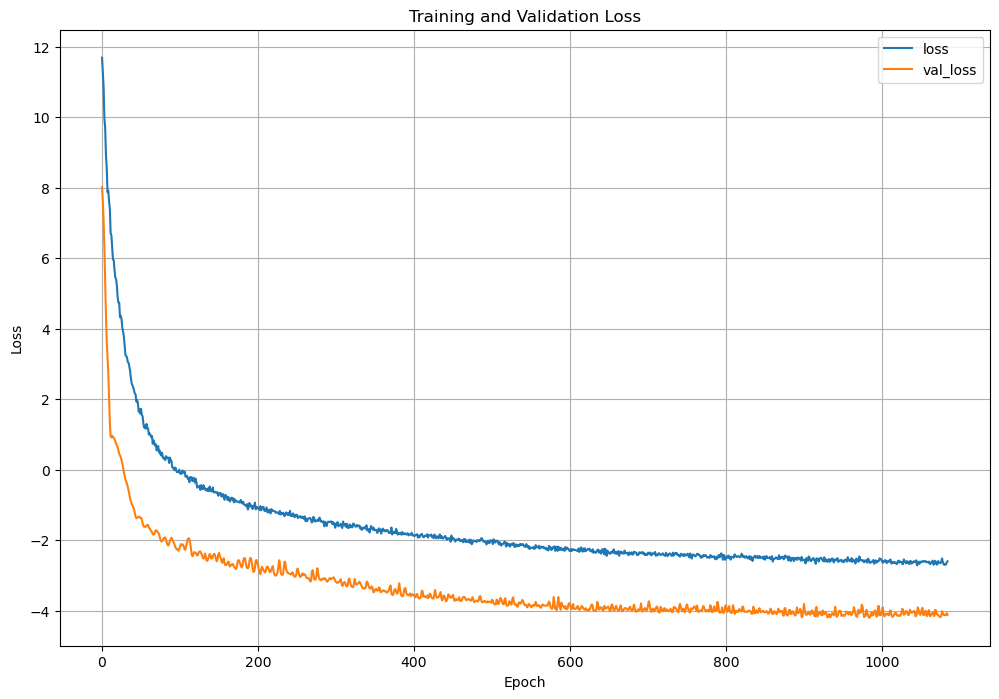

In [42]:
plot_loss(df_history)#, logy=True, ylim=[15, 25])

In [46]:
# prediction of parameters

predictions = model.predict(X_test, verbose=0)
df_predictions = pd.DataFrame(predictions)
y_mean_predict = df_predictions[df_predictions.columns[:5]]
y_sigma_predict = df_predictions[df_predictions.columns[5:]]


df_predictions


,0,1,2,3,4,5,6,7,8,9
0,-0.864514,0.467622,-0.628041,-0.254165,0.220395,0.305162,0.806741,0.768409,0.973134,0.0
1,0.999744,-0.043818,0.117392,0.244893,-0.196525,0.453407,0.949214,0.871730,0.926330,0.0
2,0.603575,0.078955,-0.102921,-0.025477,1.132279,0.435342,0.901275,0.857950,0.943599,0.0
3,0.595760,-0.056442,0.081732,0.216410,-1.243925,0.436975,0.961822,0.890677,0.929614,0.0
4,0.098567,0.026960,-0.053340,0.102001,-1.495370,0.419573,0.940518,0.889282,0.943869,0.0
...,...,...,...,...,...,...,...,...,...,...
395,0.765779,0.078426,-0.081651,0.178632,-1.418139,0.448909,0.968279,0.897091,0.937708,0.0
396,0.878255,-0.151684,0.251090,0.175363,1.083797,0.446648,0.939042,0.869836,0.928143,0.0
397,1.500940,-0.072680,0.211070,0.251754,0.697584,0.473974,0.967593,0.883487,0.905948,0.0
398,0.730757,0.064702,-0.131349,0.103208,-1.314953,0.445786,0.967017,0.908494,0.936994,0.0


/tmp/ipykernel_285003/334802014.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_285003/334802014.py:25: RuntimeWarning: divide by zero encountered in divide
  r"$\chi^2$=%.2f" %(R2, np.sum((trueY - predicY)**2/predicE**2)/(len(predicE)-2)),
/tmp/ipykernel_285003/334802014.py:41: RuntimeWarning: divide by zero encountered in divide
  ax[2].plot(trueY, (predicY-trueY)/predicE, marker=".", lw=0, markersize=2, alpha=1)
/tmp/ipykernel_285003/334802014.py:47: RuntimeWarning: divide by zero encountered in divide
  r"$\langle |bias| \rangle$=%.2f" % (np.mean((predicY-trueY)/predicE), np.mean(np.abs(predicY-trueY)/predicE)),
/home/draco/anaconda3/envs/tf_gpu/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


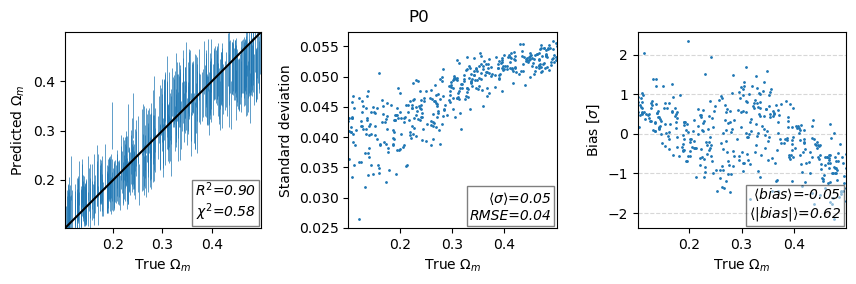

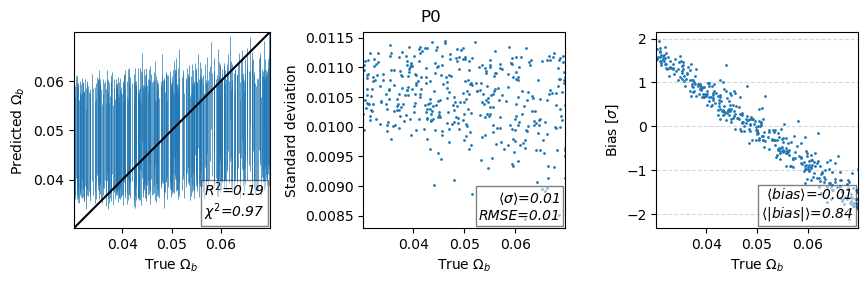

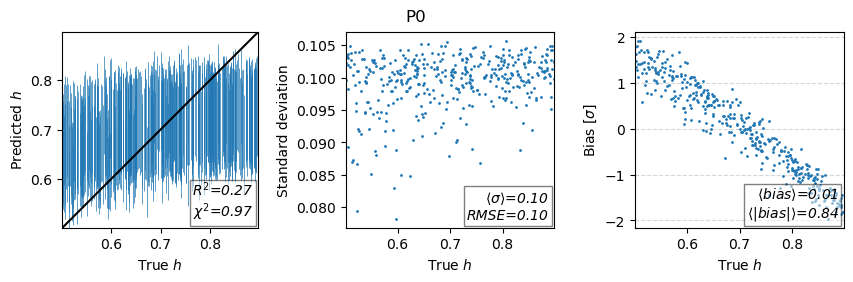

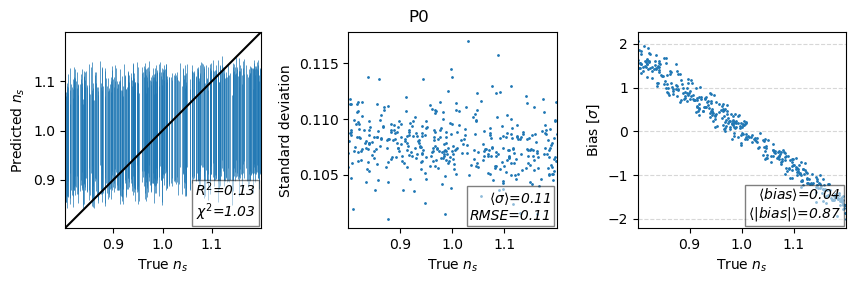

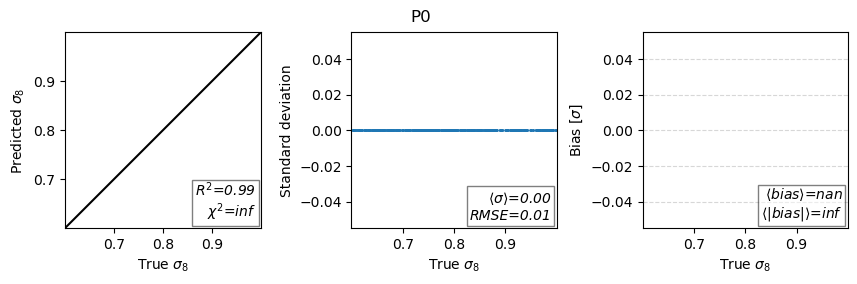

In [44]:
#
true_y = ((y_test * std_params) + mean_params).reset_index(drop=True).values
predict_y = ((y_mean_predict * std_params)  + mean_params).values
predict_E = (y_sigma_predict*std_params).values

for j in range(5):
    check_predictions(
        true_y[:,j],
        predict_y[:,j],
        predict_E[:,j],
        label=label_LaTeX_names_vanilla[j],
        title="P0")
